<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [120]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 62)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,mchno_etymd_8_norm_count,acqic_stocn_nunique,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,acqic_stscd_nunique,acqic_cano_nunique,acqic_contp_nunique,acqic_mchno_nunique,mchno_csmcu_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,mchno_stscd_nunique,acqic_mcc_nunique,acqic_etymd_6_norm_count,cano_stocn_nunique,acqic_etymd_nunique,bacno_stocn_nunique,mchno_etymd_5_norm_count,acqic_iterm_nunique,bacno_etymd_8_norm_count,acqic_contp_6_norm_count,acqic_hcefg_9_norm_count,acqic_iterm_7_norm_count,acqic_iterm_1_norm_count,mchno_etymd_4_norm_count,cano_etymd_5_norm_count,mchno_ovrlt_0_norm_count,mchno_ovrlt_1_norm_count,acqic_iterm_4_norm_count,acqic_iterm_0_norm_count,bacno_csmcu_nunique,acqic_iterm_6_norm_count,acqic_iterm_5_norm_count,acqic_contp_2_norm_count,txkey,fraud_ind
0,0,0,102,6862,0,61954,0,5,5,16158,0.001044,0.998956,0.001344,0.998656,0.0,1.0,1,2,0.0,1.0,1,0.000000,0.000000,1,3,1,0.987376,0.012624,0.000000,30627,2,33807,1,720,2,0.000000,0.000000,2,2,0.0,5,1,5,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.287500,0.985317,0.014683,0.000000,1.000000,3,0.00000,0.000000,0.000000,516056,0
1,0,0,102,0,2,38216,5795,0,5,13693,0.000016,0.997536,0.000000,0.994768,0.0,1.0,2,7,0.0,1.0,1,0.000000,0.000188,2,6,1,0.991720,0.008280,0.000000,19252,4,20139,3,188,4,0.000000,0.000000,3,23,0.0,1,3,1,0.049750,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.028673,0.130435,0.992090,0.007910,0.000000,1.000000,2,0.00000,0.000000,0.000000,4376,0
2,0,0,102,6862,0,54640,0,5,5,16158,0.001044,0.998956,0.001344,0.998656,0.0,1.0,1,2,0.0,1.0,1,0.000000,0.000000,1,3,1,0.987376,0.012624,0.000000,30627,2,33807,1,720,2,0.000000,0.000000,2,2,0.0,1,1,1,0.000000,1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.388889,0.985317,0.014683,0.000000,1.000000,2,0.00000,0.000000,0.000000,483434,0
3,0,0,102,6697,5,62128,3267,5,5,40413,0.000000,1.000000,0.000149,0.999643,0.0,1.0,101,2,0.0,1.0,1,0.142619,0.000000,1,9,1,0.988238,0.011762,0.312315,74622,3,84353,5,18121,1,0.304452,0.000000,1,126,0.0,1,6,1,0.455809,9,0.000000,0.020351,0.000482,0.002308,0.06066,0.525323,0.421053,0.987090,0.012910,0.008232,0.870099,1,0.00056,0.000227,0.008969,1407164,0
4,0,0,102,5959,4,65231,5795,5,5,25962,0.000000,1.000000,0.000038,0.999894,0.0,1.0,34,2,0.0,1.0,1,0.077908,0.000000,1,7,1,0.990016,0.009984,0.206081,41913,3,46161,4,10568,1,0.447080,0.238095,1,130,0.0,1,6,1,0.000000,1,0.192308,0.000000,0.000094,0.000000,0.00000,1.000000,0.206349,1.000000,0.000000,0.000000,1.000000,2,0.00000,0.000000,0.158531,1051004,0


# test

In [121]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 61)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,mchno_etymd_8_norm_count,acqic_stocn_nunique,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,acqic_ovrlt_1_norm_count,acqic_etymd_5_norm_count,acqic_bacno_nunique,acqic_stscd_nunique,acqic_cano_nunique,acqic_contp_nunique,acqic_mchno_nunique,mchno_csmcu_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,mchno_stscd_nunique,acqic_mcc_nunique,acqic_etymd_6_norm_count,cano_stocn_nunique,acqic_etymd_nunique,bacno_stocn_nunique,mchno_etymd_5_norm_count,acqic_iterm_nunique,bacno_etymd_8_norm_count,acqic_contp_6_norm_count,acqic_hcefg_9_norm_count,acqic_iterm_7_norm_count,acqic_iterm_1_norm_count,mchno_etymd_4_norm_count,cano_etymd_5_norm_count,mchno_ovrlt_0_norm_count,mchno_ovrlt_1_norm_count,acqic_iterm_4_norm_count,acqic_iterm_0_norm_count,bacno_csmcu_nunique,acqic_iterm_6_norm_count,acqic_iterm_5_norm_count,acqic_contp_2_norm_count,txkey
1521787,0,0,102,6862,0,77950,0,5,5,16158,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,2,0.0,0.0,2,2,0.0,1,1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97819,0.02181,0.0,1.0,1,0.0,0.0,0.0,592489
1521788,0,0,102,6862,0,79549,0,5,5,16158,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,2,0.0,0.0,2,2,0.0,1,1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97819,0.02181,0.0,1.0,1,0.0,0.0,0.0,592452
1521789,0,0,102,6862,0,60355,0,5,5,16158,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,2,0.0,0.0,2,2,0.0,1,1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97819,0.02181,0.0,1.0,1,0.0,0.0,0.0,590212
1521790,0,0,102,6862,0,60296,0,5,5,16158,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,2,0.0,0.0,2,2,0.0,1,1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97819,0.02181,0.0,1.0,1,0.0,0.0,0.0,590209
1521791,0,0,102,6862,0,77933,0,5,5,16158,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,1,2,0.181818,0.818182,2,0.0,0.0,1,3,2,0.987376,0.012624,0.0,30627,2,33807,1,720,2,0.0,0.0,2,2,0.0,1,1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.97819,0.02181,0.0,1.0,1,0.0,0.0,0.0,592488


# 定義 features & cat_features & target

In [122]:
# 全部特徵
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       ],axis=1).columns.tolist()

# 原始特徵才是cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

60 ['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg', 'contp', 'conam', 'mchno_stscd_2_norm_count', 'mchno_stscd_0_norm_count', 'acqic_stscd_2_norm_count', 'acqic_stscd_0_norm_count', 'cano_stscd_2_norm_count', 'cano_stscd_0_norm_count', 'acqic_scity_nunique', 'acqic_csmcu_nunique', 'bacno_stscd_2_norm_count', 'bacno_stscd_0_norm_count', 'cano_stscd_nunique', 'acqic_etymd_8_norm_count', 'mchno_etymd_8_norm_count', 'acqic_stocn_nunique', 'acqic_hcefg_nunique', 'bacno_stscd_nunique', 'acqic_ovrlt_0_norm_count', 'acqic_ovrlt_1_norm_count', 'acqic_etymd_5_norm_count', 'acqic_bacno_nunique', 'acqic_stscd_nunique', 'acqic_cano_nunique', 'acqic_contp_nunique', 'acqic_mchno_nunique', 'mchno_csmcu_nunique', 'acqic_etymd_4_norm_count', 'cano_etymd_8_norm_count', 'mchno_stscd_nunique', 'acqic_mcc_nunique', 'acqic_etymd_6_norm_count', 'cano_stocn_nunique', 'acqic_etymd_nunique', 'bacno_stocn_nunique', 'mchno_etymd_5_norm_count', 'acqic_iterm_nunique', 'bacno_etymd_8_norm_count

# both / test

In [123]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
contp,1.000000,交易類別
ecfg,1.000000,網路交易註記
etymd,1.000000,交易型態
stscd,1.000000,狀態碼
loctm,0.990267,授權時間
stocn,0.931034,消費地國別
hcefg,0.900000,支付型態
acqic,0.782551,收單行代碼
scity,0.667833,消費城市
conam,0.582012,交易金額-台幣(經過轉換)


# drop rare features

In [124]:
print(len(features))
try:
  features.remove('bacno')
  features.remove('cano')
except:
  pass
print(len(features))

60
60


In [125]:
print(len(cat_features))
try:
  cat_features.remove('bacno')
  cat_features.remove('cano')
except:
  pass
print(len(cat_features))

10
10


# 切分 train 跟 val_1 , val_2

In [126]:
from sklearn.model_selection import train_test_split
train ,val = train_test_split(train[features+[y_name]] ,test_size=0.25 ,random_state=42)
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.50 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1141340, 61)
(190223, 61)
(190224, 61)


# sklearn配合GridSearch的版本 搜索較優超參數

In [129]:
import lightgbm
from sklearn.model_selection import GridSearchCV

model_lgb = lightgbm.LGBMClassifier(objective = 'cross_entropy',
                                    metric = 'cross_entropy',
                                    is_unbalance = True,
                                    max_depth=7,
                                    num_leaves=2**7-1,
                                    feature_fraction = 0.8,
                                    min_child_samples = 30,
                                    n_estimators = 100,
                                    )

#調過了
params_test1={
    'max_depth': range(3,7,2),#樹深度 best 7
    'num_leaves':range(7,127,30)#樹的葉子數量 best 2**7-1
    }

#調過了
params_test2={
    'feature_fraction': np.arange(0.5,1.0,0.1), #特徵選取比例 best 0.8
    'min_child_samples':range(10,60,10) #子節點最小樣本數 best 30
    }

#調n_estimators
params_test3={
    'n_estimators': np.arange(30,100,10),#best 100
    'max_depth': range(7,8,1),#樹深度 best 7
    }

# min_data_in_leaf 和 min_sum_hessian_in_leaf
params_test4={
    'min_child_samples': [18, 19, 20, 21, 22],
    'min_child_weight': [0.001, 0.002]
    }

gsearch = GridSearchCV(estimator = model_lgb,
                        param_grid = params_test4,
                        scoring = 'f1', #評分指標
                        cv = 3, #交叉驗證次數
                        verbose = 10,
                        n_jobs = -1,
                        return_train_score = True,
                        )

gsearch.fit(train[features],train[y_name])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  8.5min remaining:   56.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.1,
                                      max_depth=7, metric='cross_entropy',
                                      min_child_samples=30,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=127,
                                      objective='cross_entropy',
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_b

# grid search結果

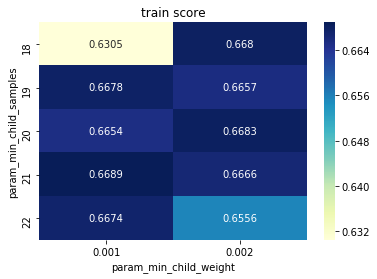

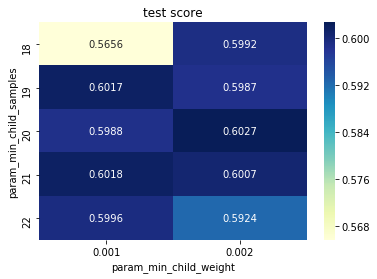

In [131]:
df_gridsearch = pd.DataFrame(gsearch.cv_results_)
max_scores = df_gridsearch.groupby(['param_min_child_samples','param_min_child_weight']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('train score')
plt.show()

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('test score')
plt.show()

# 套用上面找出的較佳超參數 train model

[1]	train's xentropy: 0.0529112	train's f1: 0	val_1's xentropy: 0.0533638	val_1's f1: 0
Training until validation scores don't improve for 30 rounds.
[2]	train's xentropy: 0.0499086	train's f1: 0	val_1's xentropy: 0.0505248	val_1's f1: 0
[3]	train's xentropy: 0.0475071	train's f1: 0.000523663	val_1's xentropy: 0.0482895	val_1's f1: 0.00157295
[4]	train's xentropy: 0.0454516	train's f1: 0.0067863	val_1's xentropy: 0.0463965	val_1's f1: 0.00627697
[5]	train's xentropy: 0.0438246	train's f1: 0.0200907	val_1's xentropy: 0.0448337	val_1's f1: 0.0202492
[6]	train's xentropy: 0.0423568	train's f1: 0.0231625	val_1's xentropy: 0.0434627	val_1's f1: 0.0217729
[7]	train's xentropy: 0.0410676	train's f1: 0.0576252	val_1's xentropy: 0.0422448	val_1's f1: 0.059293
[8]	train's xentropy: 0.0399322	train's f1: 0.109044	val_1's xentropy: 0.041191	val_1's f1: 0.113569
[9]	train's xentropy: 0.0389039	train's f1: 0.150054	val_1's xentropy: 0.0402587	val_1's f1: 0.150808
[10]	train's xentropy: 0.0379453	tra

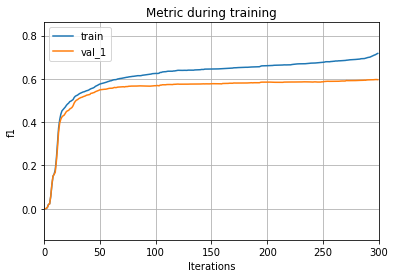

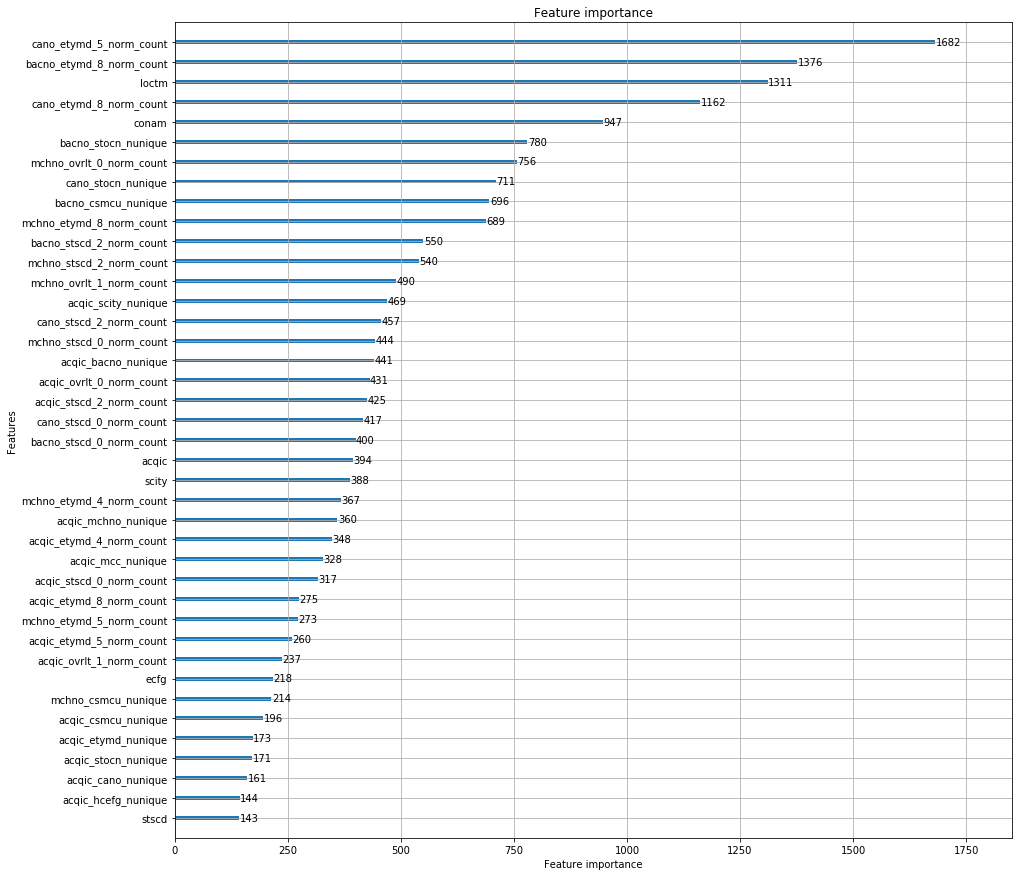

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.736652 to fit


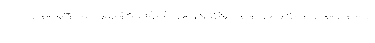

In [132]:
from sklearn.metrics import f1_score
import lightgbm
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 定義超參數  
parameters = {
    'boosting_type':'gbdt',
    'n_estimators':100,
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations': 100*3,
    'learning_rate': 0.1/2,
    'max_depth': 7,
    'num_leaves': 2**7-1,
    'feature_fraction': 0.8,
    'tree_learner': 'data',
    "is_unbalance": True,
    "early_stopping_round": 30,
    'min_child_samples': 20,
    'min_child_weight': 0.002,
    }

# train data
train_data = lightgbm.Dataset(train[features],label=train[y_name],
                              categorical_feature = cat_features)

# val_1_data
val_1_data = lightgbm.Dataset(val_1[features],label=val_1[y_name],
                              categorical_feature = cat_features)

# model training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=[val_1_data, train_data],
                       valid_names=['val_1','train'], 
                       feval=lgb_f1_score,
                       evals_result=evals_result,
                       )

# plt f1 metric
try:
  lightgbm.plot_metric(evals_result, metric='f1')
  plt.show()
except:
  pass

# plt features importance & save
try:
  ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
  plt.savefig("./features_importances.png")
  plt.show()
except:
  pass

# plt tree
try:
  ax = lightgbm.plot_tree(model,tree_index=3)
  plt.show()
except:
  pass

# plt tree_digraph
try:
  graph = lightgbm.create_tree_digraph(model,tree_index=3)
  graph.render(view=True)
except:
  pass

# val_2's F1 report

In [133]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    187682
           1       0.77      0.49      0.60      2542

    accuracy                           0.99    190224
   macro avg       0.88      0.74      0.80    190224
weighted avg       0.99      0.99      0.99    190224



# 產生submission

In [139]:
# model 1
#submission = pd.DataFrame({"txkey":test_txkey,
#                           "fraud_ind":model.predict(test[features])})

# model 2
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":gsearch.best_estimator_.predict(test[features])})

#把兩個model 做 or 運算 只要有人說是1就是1,讓1盡可能多

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    417398
1      4267
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [140]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.33816,1.33527,1.33632,1.01194


# 保存預測結果

In [0]:
submission.to_csv("./submission_32.csv")

In [144]:
print(submission["fraud_ind"].value_counts())

0    417398
1      4267
Name: fraud_ind, dtype: int64
